In [1]:
import pandas as pd

In [2]:
# train = pd.read_csv('data/technical/sales_train.csv')
# train = pd.read_csv('data/technical/test.csv')

# # begin by preparing data
#
# # begin by clipping as the competition states
# train['item_cnt_day'] = train['item_cnt_day'].clip(0, 20)
#
# # first, throw away the data from irrelevant shops
#
# shops_in_test_set = set()
# for index, row in test.iterrows():
#     shops_in_test_set.add(row['shop_id'])
#
# all_shops = set([*range(0, 60)])
# shops_missing = all_shops - shops_in_test_set
#
# for shop_missing in shops_missing:
#     index_names = train[ train['shop_id'] == shop_missing].index
#     train.drop(index_names, inplace=True)
#
# # throw away the data from irrelevant items
#
# items_in_test_set = set()
# for index, row in test.iterrows():
#     items_in_test_set.add(row['item_id'])
#
# items_in_train_set = set()
# for index,row in train.iterrows():
#     items_in_train_set.add(row['item_id'])
#
# items_missing = items_in_train_set - items_in_test_set
#
# for item_missing in items_missing:
#     train.drop(train[train['item_id'] == item_missing].index, inplace=True)
#
# # remove the month sales as we are not going to account for this in the ARIMA forecast
# train.drop(['date_block_num', 'shop_id', 'item_price'], axis=1, inplace=True)
#
# # export items
# train.to_csv("train_cleaned.csv", index=False)

In [3]:
# train = pd.read_csv('train_cleaned.csv')
#
# # to check for errors: print amount of dates in total available in the dataset
# all_dates = set()
# for index, row in train.iterrows():
#     all_dates.add(row['date'])
# len(all_dates)
#
#
# train = train.groupby(['date', 'item_id']).sum('item_cnt_day').reset_index()
#
# all_items = set()
# for index,row in train.iterrows():
#     all_items.add(row['item_id'])
#
# date_sequences_all_items = []
#
# for item in all_items:
#
#     df_this_item = train[train.item_id == item]
#
#     date_sequences_all_items.append(
#         (item, df_this_item)
#     )
#
# for sequence in date_sequences_all_items:
#     if sequence[1].shape[0] > 1000:
#         print(f"Item ID: {sequence[0]}\nData present for {sequence[1].shape[0]} days.")
#
# # allocate a new df to the most prominent item
# df = train[train.item_id == 5822].copy()
# df.drop('item_id', axis=1, inplace=True)
#
# # format the table
# df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.date
# df.sort_values(by='date', inplace=True)
# df.set_index('date', drop=True, inplace=True)
#
# df.to_csv("inspect_this_item.csv")

In [4]:
df = pd.read_csv("inspect_this_item.csv").set_index('date')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='date'>

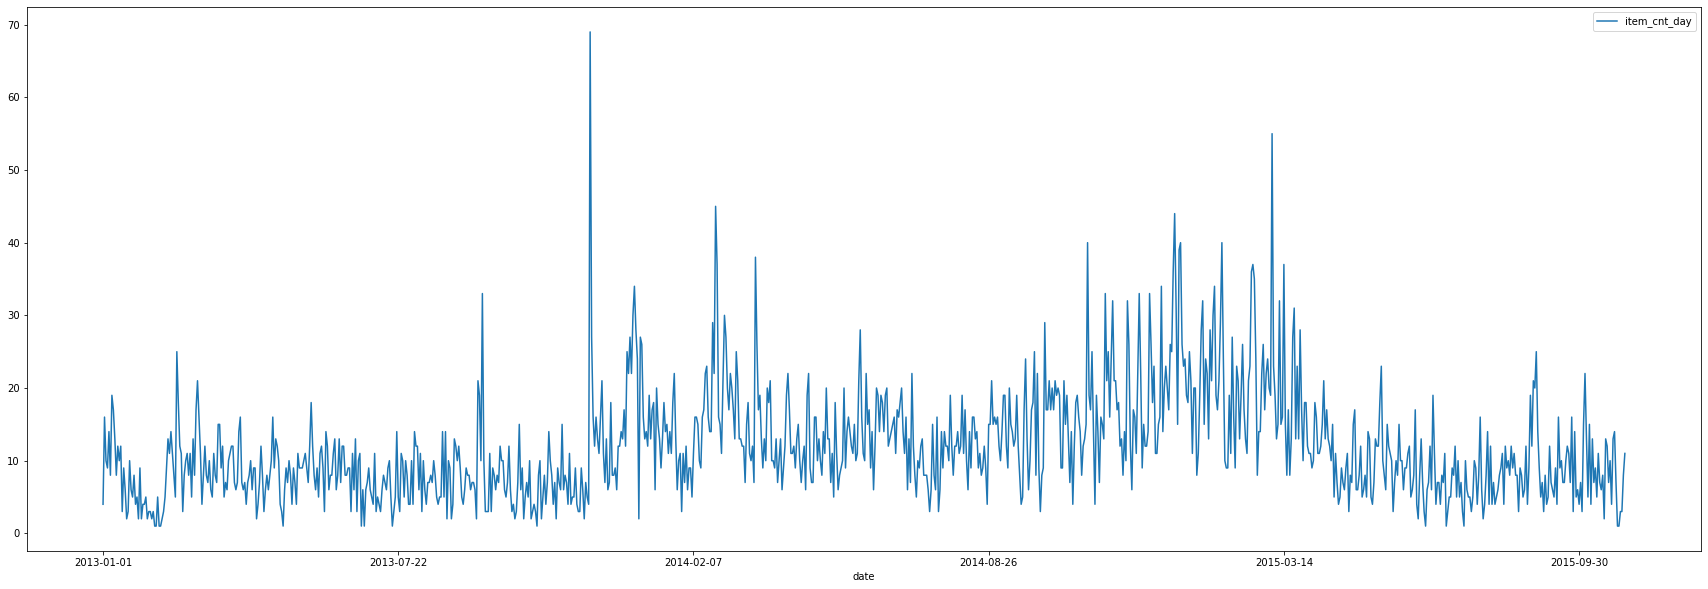

In [6]:
df.plot(figsize=(30,10))